# Arduino Sketches

Here are the sketches to implement the [weather station application](./TinyML_project_MDabrowski.ipynb) with deployed __TinyML__ model. Excluding `#if-#endif` macros for _Arduino_ board, exactly the same code can be used with different devices (e.g., _RaspberryPi Pico_) after importing proper dependencies inside another `#if-#endif` statement. For simplicity they are divided into several parts and commented but in fact they are implemented as parts of single `*.ino` files (attached to the project).
> __NOTE__: `test_` folder contains the __Arduino IDE__ sketches used for unit test of different parts of applications on both **Arduino Nano 33 BLE Sens** (with or without __DHT22__ sensor) and **RaspberryPi Pico**. To run the model deployed with __TFLu__ framework, use `classification` folder. 

## [Sensor Arduino Nano 33 BLE Sens](./arduino/sensor_arduino_nano/sensor_arduino_nano.ino)

* initialization and testing the temperature and humidity sensor on **Arduino Nano 33 BLE Sens**.
* the reason for defining function-like macros is because different microcontrollers will use other functions
* common interface with a serial port is used to communicate the sensor measurement results

```C++
#include <Arduino_HTS221.h>

#define READ_TEMPERATURE() HTS.readTemperature()
#define READ_HUMIDITY()    HTS.readHumidity()

void setup() {
  Serial.begin(9600);

  while (!Serial);

  if (!HTS.begin()) {

    Serial.println("Failed initialization of HTS221!");
    while (1);
  }
}

void loop() {
  //  Moved the read sensor values stuff from setup() to here
  Serial.print("Test Temperature = ");
  Serial.print(READ_TEMPERATURE(), 2);
  Serial.println(" °C");
  Serial.print("Test Humidity = ");
  Serial.print(READ_HUMIDITY(), 2);
  Serial.println(" %");

  delay(2000);
}
```

## [Sensor RaspberryPi Pico](./arduino/sensor_arduino_nano/sensor_rasp_pico.ino)

* initialization and testing __DHT22__ sensor (temperature and humidity) with [**RaspberryPi Pico**](https://www.upesy.com/blogs/tutorials/install-raspberry-pi-pico-on-arduino-ide-software)
* the reason for defining function-like macros is because different microcontrollers will use other functions
* this code can be used with **Arduino Nano 33 BLE Sens Less** which does not have built-it TH sensor
* __Adafruit Unified Sensor__ (Arduino IDE library manager) and __DHT Sensor Library__ (zip file included) are necessary

```C++
#include <DHT.h>

const int gpio_pin_dht_pin = 10;

DHT dht(gpio_pin_dht_pin, DHT22);

#define READ_TEMPERATURE() dht.readTemperature()
#define READ_HUMIDITY()    dht.readHumidity()

void setup() {
  Serial.begin(9600);
  while (!Serial);

  // Initialize the DHT sensor
  dht.begin();

  // Waiting for the peripheral for being ready
  delay(2000);
}

void loop() {
  Serial.print("Test Temperature = ");
  Serial.print(READ_TEMPERATURE(), 2);
  Serial.println(" °C");
  Serial.print("Test Humidity = ");
  Serial.print(READ_HUMIDITY(), 2);
  Serial.println(" %");
  
  delay(2000);
}
```

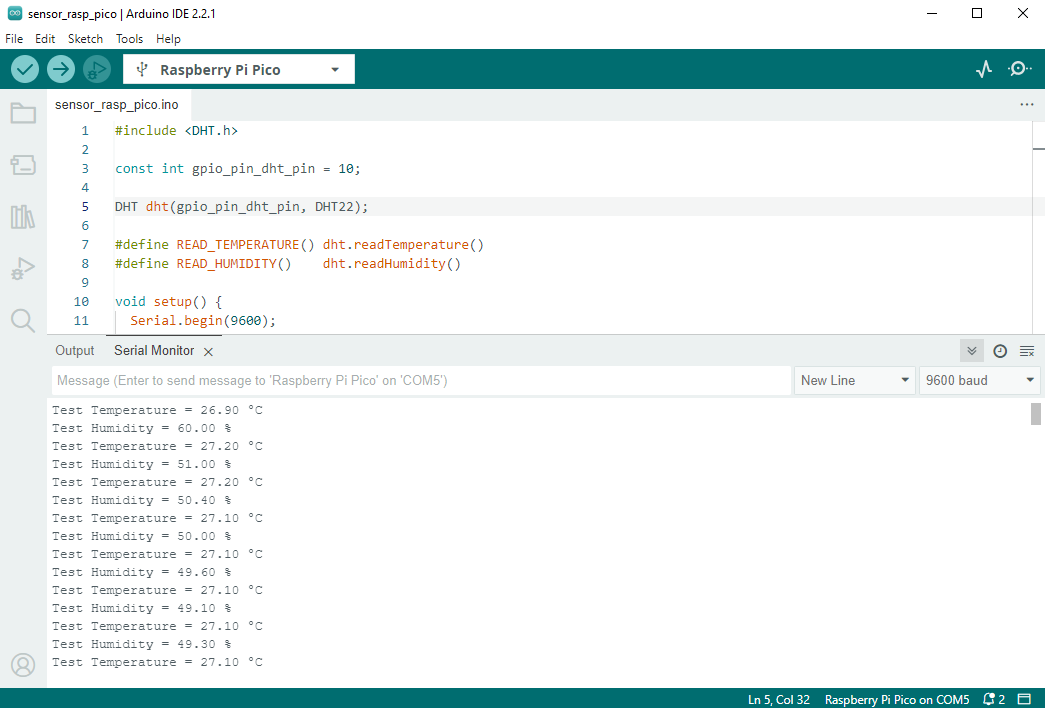

## [Input Features](./arduino/input_features/input_features.ino)

* definitions of constants, circular buffer and quantization function for a particular trained model
* the values of `constexpr` are the mean and standard deviation copied from _Feature Engineering_ step
* `quantize()` function returns `x` as an 8-bit integer, while `scale` and `zero_point` are quantization parameters

```C++
#define NUM_HOURS 3

constexpr int num_reads = 3;
constexpr float t_mean  = 4.28224f;
constexpr float h_mean  = 83.63988f;
constexpr float t_std   = 8.77749f;
constexpr float h_std   = 16.4139f;

// Circular buffers for the input features
int8_t t_vals[NUM_HOURS] = {0};
int8_t h_vals[NUM_HOURS] = {0};
int cur_idx               = 0;
float   tflu_i_scale      = 0.0f;
int32_t tflu_i_zero_point = 0;

inline int8_t quantize(float x, float scale, float zero_point)
{
  return (x / scale) + zero_point;
}
```

* Arduino Nano 33 BLE Sens board specific part of initialization code (same as before)

```C++
#if defined(ARDUINO_ARDUINO_NANO33BLE)
#include <Arduino_HTS221.h>

#define READ_TEMPERATURE() HTS.readTemperature()
#define READ_HUMIDITY()    HTS.readHumidity()

void setup() {
  Serial.begin(9600);

  while (!Serial);

  if (!HTS.begin()) {

    Serial.println("Failed initialization of HTS221!");
    while (1);
  }
}
#endif // defined(ARDUINO_ARDUINO_NANO33BLE)
```

* RaspberryPi Pico board specific part of initialization code (same as before)

```C++
#if defined(ARDUINO_RASPBERRY_PI_PICO)
#include <DHT.h>

const int gpio_pin_dht_pin = 10;

DHT dht(gpio_pin_dht_pin, DHT22);

#define READ_TEMPERATURE() dht.readTemperature()
#define READ_HUMIDITY()    dht.readHumidity()

void setup() {
  Serial.begin(9600);
  while (!Serial);

  // Initialize the DHT sensor
  dht.begin();

  // Waiting for the peripheral for being ready
  delay(2000);
}
#endif // defined(RASPBERRY_PI_PICO)
```

* main `loop()` function of the application, independent of particular microcontroller platform
* we average temperature and humidity over `num_reads=3` samples for better accuracy of the result
* after Z-score scaling the measured values are stored in `t_vals` and `h_vals` arrays
* the size of **FIFO buffer** is determined by the number of past hours `NUM_HOURS` we used in the trained model

```C++
void loop() {
  float t = 0.0f;
  float h = 0.0f;

  for(int i = 0; i < num_reads; ++i) {
    t += READ_TEMPERATURE();
    h += READ_HUMIDITY();

    delay(3000);
  }

  // Take the average
  t /= (float)num_reads;
  h /= (float)num_reads;

  Serial.print("Temperature = ");
  Serial.print(t, 2);
  Serial.println(" °C");
  Serial.print("Humidity = ");
  Serial.print(h, 2);
  Serial.println(" %");

  // Z-score scaling
  t = (t - t_mean) / t_std;
  h = (h - h_mean) / h_std;

  // Store the normalized and quantized samples in the circular buffers
  t_vals[cur_idx] = quantize(t, tflu_i_scale, tflu_i_zero_point);
  h_vals[cur_idx] = quantize(h, tflu_i_scale, tflu_i_zero_point);

  // Update the circular buffer index
  cur_idx = (cur_idx + 1) % NUM_HOURS;

  // We should have a delay of 1 hour but, for practical reasons, we have reduced it to 2 seconds
  delay(2000);
}

```

## [Classification](./arduino/classification/classification.ino)

* more information about meaning of all header files can be found in the [official documentation](https://www.tensorflow.org/lite/microcontrollers/get_started_low_level)
* `dequantize()` function is used for infering model predictions only (for comparison with full **TF** model)
* `scale` parameter is used to map our quantized value to the floating-point domain and _vice-versa_
* `zero_point` is the offset to consider for the quantized range (can be zero in a _symmetric_ case)
* __TFLu__ does not use dynamic memory allocation so we should provide a fixed amount of memory for input, output and all intermediate tensors. The size of arena depends on the specific model and is only determined by experiments (if the size is too small the application simply crash when starts running).

```C++
// Note: Set to 1 if you want to check whether the model can forecast the snow
#define DEBUG_SNOW 0

#include "model.h"

#include <TensorFlowLite.h>
#include <tensorflow/lite/micro/all_ops_resolver.h>
#include <tensorflow/lite/micro/micro_mutable_op_resolver.h>
#include <tensorflow/lite/micro/micro_error_reporter.h>
#include <tensorflow/lite/micro/micro_interpreter.h>
#include <tensorflow/lite/schema/schema_generated.h>
#include <tensorflow/lite/version.h>

#define NUM_HOURS 3

constexpr int num_reads = 3;
constexpr float t_mean  = 4.28224f;
constexpr float h_mean  = 83.63988f;
constexpr float t_std   = 8.77749f;
constexpr float h_std   = 16.4139f;

// Circular buffers for the input features
int8_t t_vals[NUM_HOURS] = {0};
int8_t h_vals[NUM_HOURS] = {0};
int cur_idx                = 0;
bool is_valid              = false;

// TensorFlow Lite for Microcontroller global variables
const tflite::Model* tflu_model            = nullptr;
tflite::MicroInterpreter* tflu_interpreter = nullptr;
TfLiteTensor* tflu_i_tensor                = nullptr;
TfLiteTensor* tflu_o_tensor                = nullptr;
tflite::MicroErrorReporter tflu_error;

constexpr int tensor_arena_size = 4 * 1024;
byte tensor_arena[tensor_arena_size] __attribute__((aligned(16)));
float   tflu_i_scale      = 0.0f;
float   tflu_o_scale      = 0.0f;
int32_t tflu_i_zero_point = 0;
int32_t tflu_o_zero_point = 0;

inline int8_t quantize(float x, float scale, float zero_point)
{
  return (x / scale) + zero_point;
}

inline float dequantize(int8_t x, float scale, float zero_point)
{
  return ((float)x - zero_point) * scale;
}
```

* loading the __TFLite__ model from the C-byte `outputs_forecast_model_tflite` array
* allocating the memory required for the model as well input and output tensors

```C++
void tflu_initialization()
{
  Serial.println("TFLu initialization - start");

  // Load the TFLITE model
  tflu_model = tflite::GetModel(outputs_forecast_model_tflite);
  if (tflu_model->version() != TFLITE_SCHEMA_VERSION) {
    Serial.print(tflu_model->version());
    Serial.println("");
    Serial.print(TFLITE_SCHEMA_VERSION);
    Serial.println("");
    while(1);
  }

  tflite::AllOpsResolver tflu_ops_resolver;

  // Initialize the TFLu interpreter
  tflu_interpreter = new tflite::MicroInterpreter(tflu_model, tflu_ops_resolver, tensor_arena, tensor_arena_size, &tflu_error);

  // Allocate TFLu internal memory
  tflu_interpreter->AllocateTensors();

  // Get the pointers for the input and output tensors
  tflu_i_tensor = tflu_interpreter->input(0);
  tflu_o_tensor = tflu_interpreter->output(0);

  const auto* i_quantization = reinterpret_cast<TfLiteAffineQuantization*>(tflu_i_tensor->quantization.params);
  const auto* o_quantization = reinterpret_cast<TfLiteAffineQuantization*>(tflu_o_tensor->quantization.params);

  // Get the quantization parameters (per-tensor quantization)
  tflu_i_scale      = i_quantization->scale->data[0];
  tflu_i_zero_point = i_quantization->zero_point->data[0];
  tflu_o_scale      = o_quantization->scale->data[0];
  tflu_o_zero_point = o_quantization->zero_point->data[0];

  Serial.println("TFLu initialization - completed");
}
```

* Arduino Nano 33 BLE Sens board specific part of initialization code (same as before) plus **TFLu** initialization

```C++
#if defined(ARDUINO_ARDUINO_NANO33BLE)
#include <Arduino_HTS221.h>

#define READ_TEMPERATURE() HTS.readTemperature()
#define READ_HUMIDITY()    HTS.readHumidity()

void setup() {
  Serial.begin(9600);

  while (!Serial);

  if (!HTS.begin()) {

    Serial.println("Failed initialization of HTS221!");
    while (1);
  }

  tflu_initialization();
}
#endif // defined(ARDUINO_NANO33_BLE_SENSE)
```

* RaspberryPi Pico board specific part of initialization code (same as before) plus __TFLu__ initialization

```C++
#if defined(ARDUINO_RASPBERRY_PI_PICO)
#include <DHT.h>

const int gpio_pin_dht_pin = 10;

DHT dht(gpio_pin_dht_pin, DHT22);

#define READ_TEMPERATURE() dht.readTemperature()
#define READ_HUMIDITY()    dht.readHumidity()

void setup() {
  Serial.begin(9600);
  while (!Serial);

  // Initialize the DHT sensor
  dht.begin();

  // Waiting for the peripheral for being ready
  delay(2000);

  tflu_initialization();
}
#endif // defined(RASPBERRY_PI_PICO)
```

* quantized values used in the __TFLu__ model need to be dequantized to make predictions
* changing `DEBUG_SNOW = 1` provides quick check if the application logic is proper (can detect snowing)

```C++
void loop() {
  float t = 0.0f;
  float h = 0.0f;

#if DEBUG_SNOW == 1
  t = -3.0f;
  h = 90.0f;
#else
  for(int i = 0; i < num_reads; ++i) {
    t += READ_TEMPERATURE();
    h += READ_HUMIDITY();

    delay(3000);
  }

  // Take the average
  t /= (float)num_reads;
  h /= (float)num_reads;
#endif

  Serial.print("Temperature = ");
  Serial.print(t, 2);
  Serial.println(" °C");
  Serial.print("Humidity = ");
  Serial.print(h, 2);
  Serial.println(" %");

  // Z-score scaling
  t = (t - t_mean) / t_std;
  h = (h - h_mean) / h_std;

  // Store the normalized and quantized samples in the circular buffers
  t_vals[cur_idx] = quantize(t, tflu_i_scale, tflu_i_zero_point);
  h_vals[cur_idx] = quantize(h, tflu_i_scale, tflu_i_zero_point);

  // Get index for the last three samples
  const int idx0 = cur_idx;
  const int idx1 = (cur_idx - 1 + NUM_HOURS) % NUM_HOURS;
  const int idx2 = (cur_idx - 2 + NUM_HOURS) % NUM_HOURS;

  // Initialize the input tensor
  tflu_i_tensor->data.int8[0] = t_vals[idx2];
  tflu_i_tensor->data.int8[1] = t_vals[idx1];
  tflu_i_tensor->data.int8[2] = t_vals[idx0];
  tflu_i_tensor->data.int8[3] = h_vals[idx2];
  tflu_i_tensor->data.int8[4] = h_vals[idx1];
  tflu_i_tensor->data.int8[5] = h_vals[idx0];

  // Run inference
  TfLiteStatus invoke_status = tflu_interpreter->Invoke();
  if (invoke_status != kTfLiteOk) {
    Serial.println("Error invoking the TFLu interpreter");
    return;
  }

  int8_t out_int8 = tflu_o_tensor->data.int8[0];
  float out_f = dequantize(out_int8, tflu_o_scale, tflu_o_zero_point);

  // After the first three samples, is_valid will be always true
  is_valid = is_valid || cur_idx == 2;

  if (is_valid) {
    if(out_f > 0.5) {
      Serial.println("Yes, it snows");
    }
    else {
      Serial.println("No, it does not snow");
    }
  }

  Serial.println();

  // Update the circular buffer index
  cur_idx = (cur_idx + 1) % NUM_HOURS;

  // We should have a delay of 1 hour but, for practical reasons, we have reduced it to 2 seconds
  delay(2000);
}
```

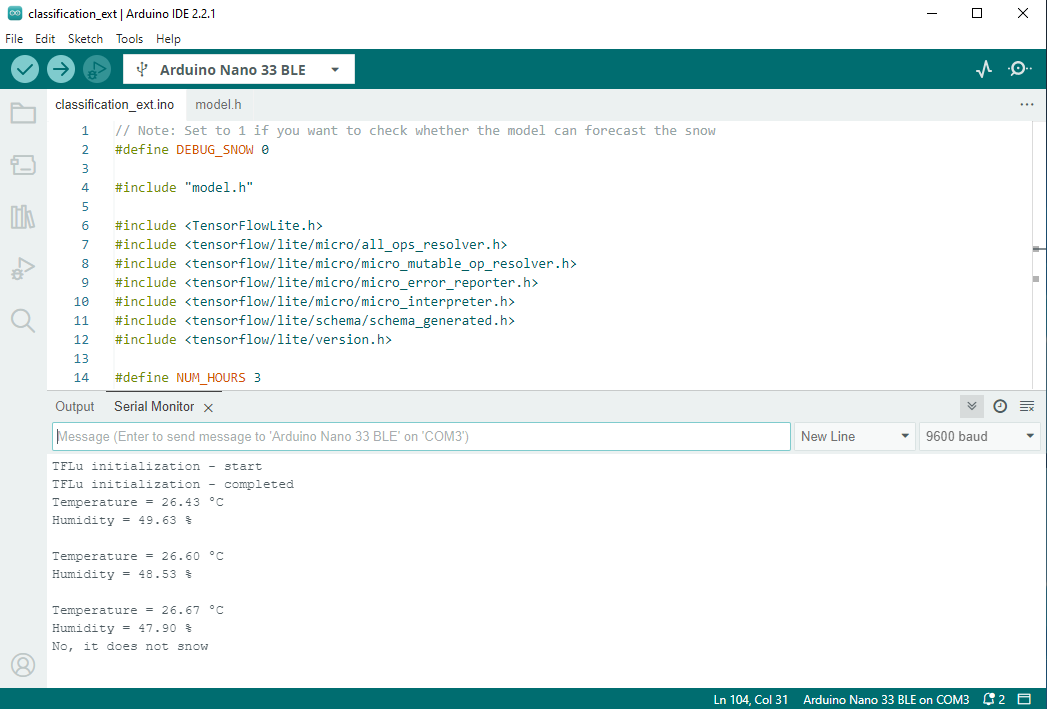